# Are types of Service Drivers of Churn

## Goal: 
    - discover drivers of churn from telco dataset
    - use machine learning to classify cutomers as likley or unlikely to churn based on drivers
    - To answer the question, to prevent churn do we need to sell more products or focus on retention? And if we need to sell more products, does the accessibility of the product matter?

## Data Dictionary:

## Imports:

In [1]:
import pydataset as data
import pandas as pd
import numpy as np
import seaborn as sns
import math
import os

from scipy import stats
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

import wrangle as w
import model as m
import explore as e

from env import get_db_url

## Acquire:

In [2]:
# uses env.py file to pull data in from SQL database
raw_data = w.get_telco_data()

## Prepare:

In [3]:
# uses function to clean and prepare data to my specifications
clean_data = w.prep_telco_data(raw_data)

#### How the data is cleaned:

- removed null variables
- dropped features I would not be exploring
- created features: 6 for charge bins, 4 for household types, 2 for service groups
- encoded features that had the option of "yes", "no", or "not applicable"

### Data Dictionary

| Term | Definition |
| --- | --- |
| Out of Sight Service | returns a count of how many of the add-on options online backup, online security, device protection, and tech support someone has |
| --- | --- |
|In Hand Services | returns a count of how many of the add-on service options of phone service, internet, streaming tv, streaming movies, and multiple lines a customer has |
| --- | --- |
|Single House| A household qualifies as single if the listed customer has no partner and no dependents|
| --- | --- |
|Dual House| A household qualifies as dual if the listed customer has a partner but is listed as not having dependents|
| --- | --- |
|Single Head House| A household is considered single head if the listed customer has dependents but does not have a partner|
| --- | --- |
|Family House| A household qualifies as a family house if the listed customer has a partner and dependents|

In [4]:
# splits cleaned data into three groups
train_df, validate_df, split_df = w.split_telco_data(clean_data)

## A brief look at the data:

In [5]:
train_df.head()

,partner,dependents,phone_service,multiple_lines,internet,online_security,online_backup,device_protection,tech_support,streaming_tv,...,single_house,dual_house,family_house,single_head_house,partner_Yes,dependents_Yes,phone_service_Yes,churn_Yes,ihs,ooss
3658,Yes,Yes,No,0,1,1,0,0,1,0,...,False,False,True,False,1,1,0,0,1,2
3865,Yes,Yes,Yes,1,0,0,0,0,0,0,...,False,False,True,False,1,1,1,0,2,0
386,No,No,Yes,0,1,0,1,1,0,0,...,True,False,False,False,0,0,1,0,2,2
1204,No,No,Yes,0,1,0,0,0,0,0,...,True,False,False,False,0,0,1,0,2,0
4570,Yes,Yes,Yes,1,1,1,1,1,1,1,...,False,False,True,False,1,1,1,0,4,4


## A summary of the data:

# Explore:

### Question 1: What is the rate of churn?

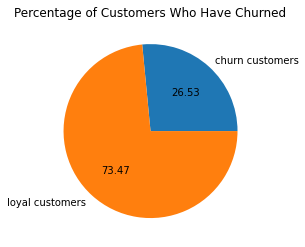

In [6]:
#baseline for churn
e.churn_pie(train_df)

explaination: stating what the viz shows

### Question 2: How does churn vary based on the makeup of a household?

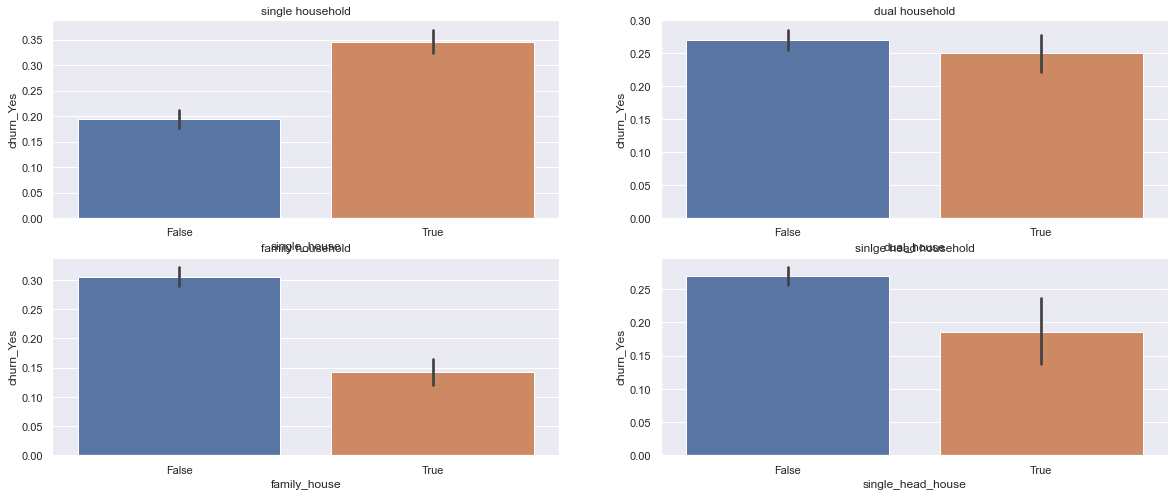

In [7]:
#code for viz
e.household_type_visualization(train_df)

The churn rate does vary significantly among different types of households. 
- The rate among single households is 9% higher than average, 
- dual households is 2% lower, 
- single head households is 10% lower 
- family households is a wopping 13% lower 

### Question 3:  Does churn rate vary between the two types of service groups?

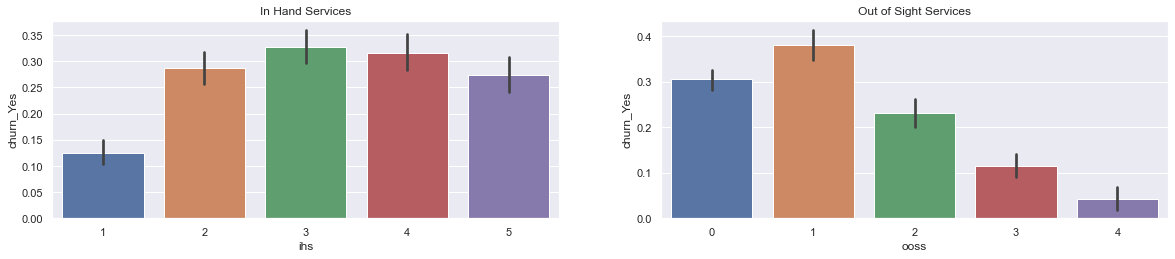

In [8]:
#code for viz
e.service_group_breakdown(train_df)

My statistics tests revelaed both groups of services have a relationship to churn, but in opposite ways. For in-hand-services, liklihood of churn increases with the number of add-ons. For out-of-sight services, the more one has the less likley they are to churn.

In [22]:
observed = pd.crosstab(train_df.ihs, train_df.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 110.1459
p     = 0.0000


In [23]:
observed = pd.crosstab(train_df.ooss, train_df.churn)
chi2, p, degf, expected = stats.chi2_contingency(observed)
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

chi^2 = 204.0386
p     = 0.0000


### Question 4: What is the Percentage Breakdown of the Out Of Sight Services?


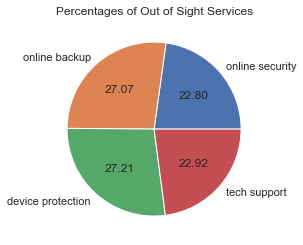

In [9]:
#code for viz
e.OOSS_breakdown(train_df)

This shows the breakdown of the out of sight services. 

# Exploration Summary:

Through my data exploration I have found the top driver of churn to be not having dependents. Since we cannot sell people children to reduce churn, I looked into what services people who churn at a higher than expected rate tend to have. I have found a threshold for a higher than expected churn rate to vary among the household types. Single, dual-head, and single head household have a much lower churn rate if they have more than 1 out of sight service. Family households have a much lower than expected churn rate if they have more than 2 out of sight services. 

# Features I am moving to Modeling: 
### online security, online backup, device protection, tech support, Out of Sight Services

In [24]:
# refernce for baseline accuracy
train_df.churn.value_counts(normalize = True)

No     0.73472
Yes    0.26528
Name: churn, dtype: float64

# Modeling:

In [16]:
model_ready_data = m.model_dataframe(clean_data)

In [17]:
train_X, validate_X, test_X, train_y, validate_y, test_y = m.final_split(model_ready_data, "churn")

### Decision tree

In [18]:
m.decision_tree(train_X, validate_X, train_y, validate_y)

Accuracy of Decision Tree statistical model on training data is 0.7347197565305605
Accuracy of Decision Tree statistical model on validation data is 0.7344766410408042


### Random Forest

In [19]:
m.random_forest(train_X, validate_X, train_y, validate_y)

Accuracy of Random Forest statistical model on training data is 0.7347197565305605
Accuracy of Random Forest statistical model on validation data is 0.7344766410408042


### Logistic Regression

In [20]:
m.log_reg(train_X, validate_X, train_y, validate_y)

Accuracy of Logistic Regression on train is 0.7347197565305605
Accuracy of Logistic Regression on validate is 0.7344766410408042


## Comparing models

# Model on Test Set

### Modeling Summary:

In [21]:
m.log_test(test_X, test_y)

Accuracy of Logistic Regression on train is 0.7345635202271115


# Conclusions:

""" 

### Exploration:
- In my exploration I discovered a few significant indicators of churn

### Modeling:

### Recommendations:

### Next Steps: